<a href="https://colab.research.google.com/github/aCStandke/ReinforcementLearning/blob/main/modelTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ignore warning messages because they are annoying lol
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install stable-baselines3[extra] # reinforcement learning library
!pip install optuna # hyperparameter library
!pip install --upgrade importlib-metadata==4.13.0 # for backwards compatibility issue
!pip install empyrical # financial calculation library
!pip install yfinance # yahoo finance for test data

In [30]:
import random
import gym 
from gym import spaces
from gym.utils import seeding
import pandas as pd
import numpy as np
import seaborn as sns
import json
import datetime as dt
import optuna
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
from stable_baselines3 import PPO
from stable_baselines3.common.utils import constant_fn
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import VecCheckNan, check_env
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, StopTrainingOnRewardThreshold
from stable_baselines3.common.logger import configure
from empyrical import sortino_ratio, omega_ratio
import sqlite3
from sqlite3 import Error
import torch as th
import torch.nn as nn
from torch.distributions.categorical import Categorical
import collections
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
import os
import csv
from csv import DictWriter
from matplotlib import style
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
# getting traing data
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/aCStandke/stunning-adventure/master/iyt.us.txt
test_data = yf.download("iyt", "2018-12-8", "2019-12-8")

In [6]:
# stock environment parameters
MAX_ACCOUNT_BALANCE = 2147483647 
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 4294967295
LOOKBACK_WINDOW_SIZE = 30 # trading window, default is 30 frames 
MAX_STEPS = 2e5 # num of iterations, default is 200,000
INITIAL_ACCOUNT_BALANCE = 10000 # starting balance and networth
# default percentage of stock price trading agent pays broker when 
# buying/selling, default is 0.1% (i.e. very reasonable)
DA_COMMISION = 0.1
# validation frequency
FEQ = MAX_STEPS/10
# the number of concurrent environments for training  
ENV = 1
MODEL = "MLP_IYT"
POLICY = 'Mlp'

In [7]:
# Stock/ETF Trading Enviornment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, data, title, reward_func='sortinoRewardRatio', r=False, random=True, volumes=True):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.random_ofs_on_reset = random
        self.reward_func = reward_func
        self.bars_count = LOOKBACK_WINDOW_SIZE
        self.commission = DA_COMMISION
        self.title = title
        self.volumes = volumes
        self._render_ja = r
        
        # Actions of the format Buy x%, Sell x%, Hold x%
        # the action space is 2 x 10 = 30 that agent can execute
        self.action_space = spaces.MultiDiscrete([3, 10])

        # Prices contains the OHCL values for the last five prices the 
        # observation space is 6 x 10 = 60 that agent can observe
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32)
        
        # setting random seed
        self.seed()

        # creating header for text output
        if self._render_ja == True:
          header = "Time, Networth, Balence, SharesHeld"
          with open(self.title, 'a') as f:
            f.write(header + "\n")
            f.close

    def reset(self):
      # random offset portion 
      bars = self.bars_count
      if self.random_ofs_on_reset:
        offset = self.np_random.choice(self.data.high.shape[0]-bars*10)+bars
      else:
        offset = bars
      self._reset(offset)
      return self._next_observation()

    def _reset(self, offset):
      self.trades = []
      self.balance = INITIAL_ACCOUNT_BALANCE
      self.netWorth = INITIAL_ACCOUNT_BALANCE
      self.max_net_worth = INITIAL_ACCOUNT_BALANCE
      self.shares_held  = 0
      self._offset = offset
      # setting account history portion
      self.account_history = np.repeat([[self.netWorth],
                                        [self.balance],
                                        [self.shares_held]], self.bars_count, axis=1)

    # shape of observation space is 2D
    @property
    def shape(self):
      if self.volumes:
        return (8, self.bars_count)
      else:
        return (7, self.bars_count)

    def _next_observation(self):
      res = np.zeros(shape=self.shape, dtype=np.float32)
      ofs = self.bars_count-1
      # price data
      res[0] = self.data.high[self._offset-ofs:self._offset+1]
      res[1] = self.data.low[self._offset-ofs:self._offset+1]
      res[2] = self.data.open[self._offset-ofs:self._offset+1]
      res[3] = self.data.close[self._offset-ofs:self._offset+1]
      # networth
      res[4] = self.account_history[0][-self.bars_count:]
      # balance
      res[5] = self.account_history[1][-self.bars_count:]
      # shares
      res[6] = self.account_history[2][-self.bars_count:]
      if self.volumes:
        # volume
        res[7] = self.data.volume[self._offset-ofs:self._offset+1]
      return res

       
    def _take_action(self, action):
      reward = 0
      current_price = self._cur_close()
      action_type = action[0]
      amount = action[1]/10

      shares_bought = 0
      shares_sold = 0
      additional_cost = 0
      sales = 0

      if action_type < 1 and int(self.balance) > 0 and action[1] > 0:
        # Buy amount % of balance in shares
        total_possible = self.balance / (current_price * (1+self.commission))
        shares_bought = total_possible * amount
        additional_cost = shares_bought * current_price * (1+self.commission)
        self.balance -= additional_cost
        self.shares_held += shares_bought
        # trading history
        if shares_bought > 0:
          self.trades.append({'step': self._offset, 'shares': shares_bought, 
                              'total': additional_cost, 'type': "buy"})
      elif action_type < 2 and int(self.shares_held) > 0 and action[1] > 0:
        # Sell amount % of shares held
        shares_sold = self.shares_held * amount  
        sales = shares_sold * current_price * (1 - self.commission)
        self.balance += sales
        self.shares_held -= shares_sold
        # trading history
        if shares_sold > 0:
          self.trades.append({'step': self._offset, 'shares': -shares_sold, 
                              'total': shares_sold * current_price, 'type': "sell"}) 
      else:
        # Hold and ride the bull or bear
        pass    
      
      self.netWorth = self.balance + self.shares_held * current_price
        

      # updating account history
      self.account_history = np.append(self.account_history, [[self.netWorth],
                                                              [self.balance],
                                                              [self.shares_held]],axis=1)
      
      # reward Calculations based off networth history
      returns = self.account_history[0][-self.bars_count:]
      # calcualtion for ratio based rewards
      r = np.diff(returns)
      # sortinoRewardRatio
      if self.reward_func == 'sortinoRewardRatio':
        ratio = sortino_ratio(r, period="daily") # default period daily
        reward= ratio 
        if self.netWorth > self.max_net_worth:
          self.max_net_worth = self.netWorth
          reward *= 100
      # Omega Ratio
      elif self.reward_func == 'omegaRewardRatio':
        ratio = omega_ratio(r) 
        reward= ratio
        if self.netWorth > self.max_net_worth:
          self.max_net_worth = self.netWorth
          reward *= 100
      # None
      else:
        reward = sum(r)*10
        if self.netWorth > self.max_net_worth:
          self.max_net_worth = self.netWorth
          reward *= 100
      return reward if abs(reward) != np.inf and not np.isnan(reward) else 0

      
    def _cur_close(self):
      """
      Calculate real close price for the current bar
      """
      return self.data.real_close[self._offset]

    def step(self, action):
      # Execute one time step within the environment
      reward = self._take_action(action)
      self._offset += 1
      if self._offset >= self.data.close.shape[0]-1 or int(self.netWorth)<1 or int(self.netWorth)>=MAX_ACCOUNT_BALANCE:
        done=True
      else:
        done=False
      obs = self._next_observation()
      info = {"Net Worth":self.netWorth, "reward": reward, 'Balance': self.balance}
      return obs, reward, done, info

    def _render_to_file(self):
      with open(self.title, 'a') as f:
        f.write(f'{self.data.date[self._offset]},{self.netWorth},{self.balance},{self.shares_held}\n')
        f.close()
 
    def render(self, mode='file', title="Agent's Trading Screen", **kwargs):
      # Render the environment to the screen
      if mode == 'file':
        if self._render_ja == True:
          self._render_to_file()


    def seed(self, seed=None):
      self.np_random, seed1 = seeding.np_random(seed)
      seed2 = seeding.hash_seed(seed1+1) % 2**33
      return [seed1, seed2]


In [9]:
# create a log-differenced series (i.e. lag one) to create stationary input
# as detailed by Jason in his post 
# https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = np.log(dataset[i]) - np.log(dataset[i - interval])
		diff.append(value)
	return diff

In [10]:
# training data
df = pd.read_csv('iyt.us.txt') # load csv data from directory
df = df.sort_values('Date')
data=df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# making OHLC data stationary  
o = np.array(difference(data['Open'], 1))
rh = np.array(difference(data['High'], 1))
rl = np.array(difference(data['Low'], 1))
rc = np.array(difference(data['Close'], 1))
# volumne data
vol = data['Volume'].values
# year data of year-month-day form
dt = data['Date'].array


Train_Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume', 'real_open',  'real_close', 'real_high', 'real_low', 'real_vol'])
train = Train_Data(date=dt,high=rh, low=rl, close=rc, open=o, volume=vol, real_open=data['Open'].values, real_close=data['Close'].values, real_high=data['High'].values, real_low=data['Low'].values, real_vol=data['Volume'].values)

In [17]:
# Testing data
test_data['Date']=test_data.index
data_two=test_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# making OHLC data stationary  
diff_o = np.array(difference(data_two['Open'], 1))
diff_h = np.array(difference(data_two['High'], 1))
diff_l = np.array(difference(data_two['Low'], 1))
diff_c = np.array(difference(data_two['Close'], 1))
# volumne data
vols = data_two['Volume'].values
# year data of year-month-day form
date = data_two['Date'].array

Test_Data = collections.namedtuple('Data', field_names=['date','high', 'low', 'close', 'open', 'volume', 'real_open', 'real_close', 'real_high', 'real_low', 'real_vol'])
test = Test_Data(date=date,high=diff_h, low=diff_l, close=diff_c, open=diff_o, volume=vols, real_open=data_two['Open'].values, real_close=data_two['Close'].values, real_high=data_two['High'].values, real_low=data_two['Low'].values, real_vol=data_two['Volume'].values)

In [19]:
def evaluate_policy(model,env,n_eval_episodes=1,deterministic=False):
    episode_rewards, networths, episode_balances = [], [], []
    for i in range(n_eval_episodes):
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        episode_balance = 0
        networth = 0
        obs = env.reset()
        while not done:
            action, state = model.predict(obs, state=state, deterministic=deterministic)
            new_obs, reward, done, _info = env.step(action)
            obs = new_obs
            episode_reward += reward
            episode_balance += _info[0]['Balance']
            networth += _info[0]['Net Worth']
        episode_rewards.append(episode_reward)
        episode_balances.append(episode_balance)
        networths.append(networth)
    mean_reward = np.mean(episode_rewards)
    mean_networth = np.mean(networths)
    mean_balance = np.mean(episode_balances)
    return mean_reward, _info[0]['Net Worth'], _info[0]['Balance']


class TensorboardCallback(BaseCallback):
    def __init__(self, env, eval,  verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.eval= eval
        self.env = env

    def _on_step(self):
      if (self.num_timesteps % self.eval == 0):
        m, net, bal = evaluate_policy(self.model, self.env)
        self.logger.record('Last Networth Value', net)
        self.logger.record('Last Balance Value', bal)
      return True

In [ ]:
# create evaluation env that takes in test data that saves best model 
eval_env = DummyVecEnv([lambda: StockTradingEnv(test, f'{MODEL}.txt', random=False, volumes=False)])
eval_callback = EvalCallback(eval_env, best_model_save_path=f'{MODEL}',
                             log_path=f'{MODEL}_log', eval_freq=FEQ,
                             deterministic=False, render=False, n_eval_episodes=1)

# create training envs that takes in training data for training
envs =  DummyVecEnv([lambda: StockTradingEnv(train, f'{MODEL}.txt', random=True, volumes=False) for _ in range(0,ENV)])


# optional additional keyword parameters to pass to Mlp model 
policy_kwargs = dict()


# creating callback list for tracking purposes 
callback = CallbackList([TensorboardCallback(eval_env, FEQ), eval_callback])


model = PPO('MlpPolicy', envs,  verbose=1, tensorboard_log=f"/content/tensorboard", policy_kwargs=policy_kwargs)

# check to make sure no erros in the env, such as observation space errors or nans
check_env(StockTradingEnv(train, f'{MODEL}.txt', random=True, volumes=False))
VecCheckNan(envs, raise_exception=True, check_inf=True)
model.learn(total_timesteps=MAX_STEPS, callback=callback)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/tensorboard/

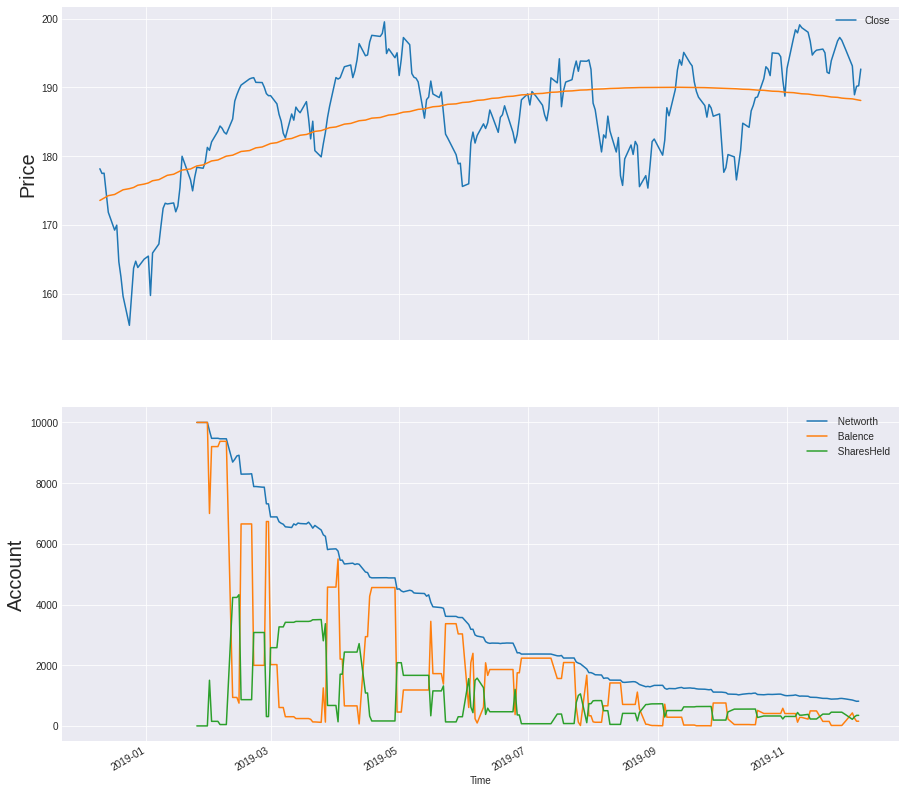

In [31]:
model = PPO.load(f'{MODEL}/best_model.zip')
env = StockTradingEnv(test, f'{MODEL}.txt', r=True, random=False, volumes=False)
obs = env.reset()
for i in range(len(test.date)):
  action, _states = model.predict(obs, deterministic=False)
  obs, rewards, done, info = env.step(action)
  env.render()
  if done:
    break
df = pd.read_csv(f'{MODEL}.txt')
df[' SharesHeld']=df[' SharesHeld']*100
# create numpy array to fit regression line
x = np.arange(data_two['Close'].size)
fit = np.polyfit(x, data_two['Close'], deg=2)
fit_function = np.poly1d(fit)
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
data_two["Date"] = pd.to_datetime(data_two['Date'], format='%Y-%m-%d')
data_two.plot(ax=axes[0], x='Date', y='Close')
axes[0].set_ylabel('Price', fontsize=20)
#Linear regression plot
sns.lineplot(ax=axes[0], x=data_two['Close'].index ,y=fit_function(x))
df["Time"] = pd.to_datetime(df['Time'], format='%Y-%m-%d')
df.plot(ax=axes[1], x="Time", y=[' Networth', ' Balence', ' SharesHeld'])
axes[1].set_ylabel('Account', fontsize=20)
fig.set_figwidth(15)
fig.set_figheight(15)
fig.savefig(f'{MODEL}.png')